# Exercises

## Acquire (`acquire.py`)

### Zillow
**For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.**

**You will have a** 
`zillow.ipynb` 
**file and a helper file for each section in the pipeline.**

In [1]:
###############################################################################
### python imports                                                          ###
###############################################################################

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler


import warnings
warnings.filterwarnings("ignore")

# from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
###############################################################################
### local imports                                                           ###
###############################################################################

import acquire as acq
import prepare as prep
import clusterfunctions as cf

from debug import local_settings, timeifdebug, timeargsifdebug, frame_splain
from dfo import DFO, set_dfo
from prepare import convert_to_dates, get_column_values_stats, retype_cols, remove_cols, nulls_by_row

In [3]:
local_settings.splain=True
local_settings.debug=True
splain = local_settings.splain
debug = local_settings.debug

In [4]:
from wrangle_zillow import get_zillow_data, get_zillow_local_data, prep_zillow_data, sqls, keep_cols

#### Acquire & Summarize

1. **Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.**

   - *Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for* 
`airconditioningtypeid`
*.*
   - Only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property ID's), along with zestimate error and date of transaction.
   - Only include properties that include a latitude and longitude value.

In [5]:
# dfo = set_dfo(get_zillow_data(sql=sqls['mvp']), splain=True)
dfo = set_dfo(get_zillow_local_data(csv='zillow_local_mvp.csv'), splain=True)

2019-11-07 15:16:37 starting get_zillow_local_data
2019-11-07 15:16:37 starting csv_df
2019-11-07 15:16:37 starting check_df
2019-11-07 15:16:37 starting frame_splain
DATAFRAME SHAPE:
(52089, 10) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52089 entries, 0 to 52088
Data columns (total 10 columns):
Unnamed: 0                      52089 non-null int64
parcelid                        52089 non-null int64
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8), int64(2)
memory usage: 4.0 MB
None 

DATAFRAME DESCRIPTION:
                                count          mean

2. **Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.).**

In [6]:
df = dfo.df

In [7]:
df = remove_cols(df, ['Unnamed: 0'])

2019-11-07 15:16:37 starting remove_cols
2019-11-07 15:16:37 ending remove_cols ; time: 0:00:00.002595


In [8]:
dfo.index_columns = 'parcelid'

In [9]:
dfo.y_column = 'logerror'

In [10]:
df = df.set_index(dfo.index_columns)

In [11]:
frame_splain(df, title='Zillow Data', splain=True)

2019-11-07 15:16:37 starting frame_splain
ZILLOW DATA SHAPE:
(52089, 8) 

ZILLOW DATA INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB
None 

ZILLOW DATA DESCRIPTION:
                                count          mean            std  \
bathroomcnt                   52089.0  2.305669e+00       1.017265   
bedroomcnt                    52089.0  3.309912e+00       0.933453   
calculatedfinishedsquarefeet  52089.0  1.923432e+03    1003.068834  

In [12]:
date_columns = ['transactiondate']
df = convert_to_dates(df, cols=date_columns)

2019-11-07 15:16:37 starting convert_to_dates
2019-11-07 15:16:37 ending convert_to_dates ; time: 0:00:00.000268


In [13]:
df.head(15)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,structuretaxvaluedollarcnt,structuredollarpersqft,logerror
parcelid,,,,,,,,
14297519,3.5,4.0,3100.0,33634931.0,-117869207.0,485713.0,156.681613,0.025595
17052889,1.0,2.0,1465.0,34449266.0,-119281531.0,88000.0,60.068259,0.055619
14186244,2.0,3.0,1243.0,33886168.0,-117823170.0,85289.0,68.615447,0.005383
12177905,3.0,4.0,2376.0,34245180.0,-118240722.0,108918.0,45.840909,-0.103410
12095076,3.0,4.0,2962.0,34145202.0,-118179824.0,276684.0,93.411209,-0.001011
12069064,1.0,2.0,738.0,34149214.0,-118239357.0,18890.0,25.596206,0.101723
12790562,3.0,4.0,3039.0,33960230.0,-118006914.0,177527.0,58.416255,-0.040966
11104527,3.0,4.0,2540.0,34434971.0,-118464390.0,271715.0,106.974409,0.005963
13944538,2.5,3.0,1340.0,33771438.0,-117982834.0,96617.0,72.102239,0.045602


In [14]:
frame_splain(df, splain=True)

2019-11-07 15:16:37 starting frame_splain
DATAFRAME SHAPE:
(52089, 8) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB
None 

DATAFRAME DESCRIPTION:
                                count          mean            std  \
bathroomcnt                   52089.0  2.305669e+00       1.017265   
bedroomcnt                    52089.0  3.309912e+00       0.933453   
calculatedfinishedsquarefeet  52089.0  1.923432e+03    1003.068834   
lati

**Find string categoricals**

In [15]:
df_strings = get_column_values_stats(
    df, 
    get_cols=df.columns[df.dtypes=='object'],
    max_uniques=20000,
    limit_to_max=True
)
df_strings

2019-11-07 15:16:37 starting get_column_values_stats
2019-11-07 15:16:38 ending get_column_values_stats ; time: 0:00:00.166760


,dtype,num_rows_values,num_rows_missing,pct_rows_missing,num_uniques,unique_values
cols,,,,,,
bathroomcnt,float64,52089,0,0.0,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ..."
bedroomcnt,float64,52089,0,0.0,13,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 8.0, 9.0, ..."
calculatedfinishedsquarefeet,float64,52089,0,0.0,4710,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0..."


In [16]:
df_strings.index

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'], dtype='object', name='cols')

In [17]:
string_categoricals = [
    'airconditioningdesc', 
    'architecturalstyledesc', 
    'buildingclassdesc', 
    'county', 
    'state', 
    'heatingorsystemdesc', 
    'propertycountylandusecode', 
    'propertylandusedesc', 
    'propertyzoningdesc', 
    'storydesc', 
    'taxdelinquencyflag', 
    'typeconstructiondesc'
]

In [18]:
df = retype_cols(df, cols=string_categoricals, to_dtype='category')
df.info()

2019-11-07 15:16:38 starting retype_cols
2019-11-07 15:16:38 ending retype_cols ; time: 0:00:00.002145
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB


**Find Numeric Categoricals**

In [19]:
df_cat_check = prep.get_column_values_stats(
    df, 
    get_cols=df.columns[df.dtypes!='category'],
    max_uniques=750000,
    target_col=dfo.y_column,
    limit_to_max=True
)
df_cat_check

2019-11-07 15:16:38 starting get_column_values_stats
2019-11-07 15:16:38 ending get_column_values_stats ; time: 0:00:00.163884


,dtype,num_rows_values,num_rows_missing,pct_rows_missing,num_uniques,unique_values
cols,,,,,,
bathroomcnt,float64,52089,0,0.0,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ..."
bedroomcnt,float64,52089,0,0.0,13,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 8.0, 9.0, ..."
calculatedfinishedsquarefeet,float64,52089,0,0.0,4710,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0..."
latitude,float64,52089,0,0.0,50293,"[33634931.0, 34449266.0, 33886168.0, 34245180...."
longitude,float64,52089,0,0.0,50571,"[-117869207.0, -119281531.0, -117823170.0, -11..."
structuretaxvaluedollarcnt,float64,52089,0,0.0,37220,"[485713.0, 88000.0, 85289.0, 108918.0, 276684...."
structuredollarpersqft,float64,52089,0,0.0,51809,"[156.6816129032258, 60.068259385665534, 68.615..."


In [20]:
df_cat_check.index

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'structuretaxvaluedollarcnt', 'structuredollarpersqft'],
      dtype='object', name='cols')

In [21]:
numeric_categoricals = [
    'airconditioningtypeid', 
    'architecturalstyletypeid', 
    'buildingclasstypeid', 
    'buildingqualitytypeid',
    'decktypeid', 
    'fips', 
    'hashottuborspa',
    'heatingorsystemtypeid',
    'pooltypeid10', 
    'pooltypeid2', 
    'pooltypeid7', 
    'propertylandusetypeid',
    'regionidcounty', 
    'regionidcity',
    'regionidneighborhood',
    'regionidzip',
    'rawcensustractandblock',
    'censustractandblock',
    'storytypeid', 
    'threequarterbathnbr', 
    'numberofstories', 
    'fireplaceflag', 
    'assessmentyear', 
    'typeconstructiontypeid', 
    'transactions'
]

In [22]:
df = retype_cols(df, cols=numeric_categoricals, to_dtype='category')
df.info()

2019-11-07 15:16:38 starting retype_cols
2019-11-07 15:16:38 ending retype_cols ; time: 0:00:00.004039
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB


In [23]:
nulls_by_row(df)

2019-11-07 15:16:38 starting nulls_by_row
2019-11-07 15:16:38 ending nulls_by_row ; time: 0:00:00.067326


,num_cols_missing,pct_cols_missing,parcelid
0,0,0.0,52089


In [24]:
# check_outlier_cols =

#### Prepare

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

2. Create a function that will drop rows or columns based on the percent of values that are missing: `handle_missing_values(df, prop_required_column, prop_required_row)`.

   - The input:
       - A dataframe
       - A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
       - A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
   - The output:
       - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
   - hint:
       - Look up the dropna documentation.
       - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
       - Make use of inplace, i.e. inplace=True/False.

In [25]:
# def handle_missing_values(
#     df, 
#     prop_required_column, 
#     prop_required_row
#     ):
#     '''
#     handle_missing_values(
#     df, 
#     prop_required_column=.9, 
#     prop_required_row=.9
#     )
#     '''
    

3. Decide how to handle the remaining missing values:
   - Fill with constant value.
   - Impute with mean, median, mode.
   - Drop row/column

In [26]:
# df_sqft = df[['calculatedfinishedsquarefeet',
# 'finishedfloor1squarefeet',
# 'finishedsquarefeet6',
# 'finishedsquarefeet12',
# 'finishedsquarefeet13',
# 'finishedsquarefeet15',
# 'finishedsquarefeet50'
# ]]

#### `wrangle_zillow.py`

Functions of the work above needed to acquire and prepare a new sample of data.

In [27]:
# df_sqft[df_sqft.calculatedfinishedsquarefeet.isna() & (df_sqft.finishedsquarefeet50.isna()==False)]

In [28]:
# df_pool = df[['poolcnt','poolsizesum','pooltypeid2','pooltypeid7','pooltypeid10']]
# df_pool[(df_pool.poolcnt.isna()==False) | (df_pool.pooltypeid10.isna()==False)]

In [29]:
dfo.df = df
dfo.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB


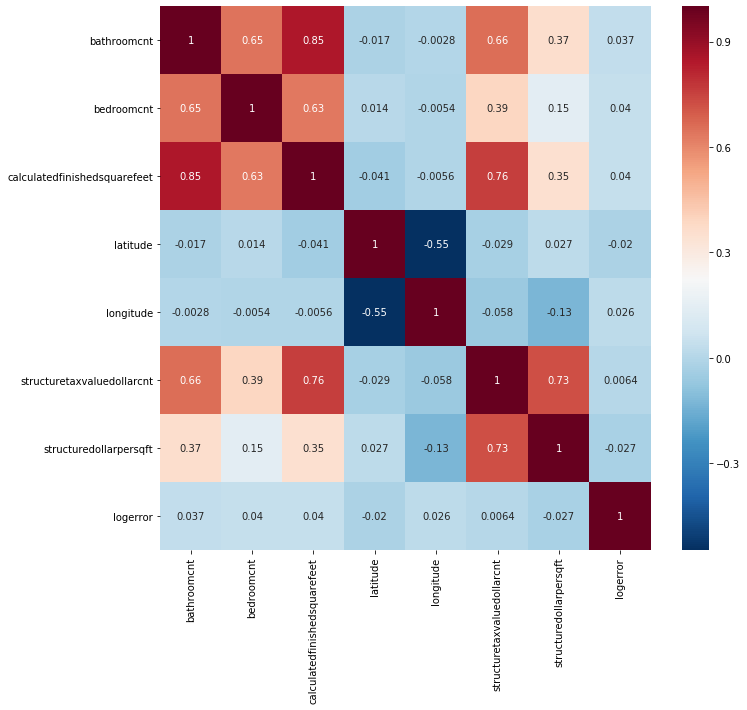

In [30]:
plt.figure(figsize=(11,10))
cor = df.corr()
plot = sns.heatmap(cor, annot=True, cmap=plt.cm.RdBu_r)


In [31]:
df.corr()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,structuretaxvaluedollarcnt,structuredollarpersqft,logerror
bathroomcnt,1.000000,0.647641,0.852965,-0.017218,-0.002820,0.660065,0.365242,0.037370
bedroomcnt,0.647641,1.000000,0.634529,0.013560,-0.005412,0.390788,0.145150,0.039670
calculatedfinishedsquarefeet,0.852965,0.634529,1.000000,-0.040970,-0.005573,0.761486,0.353193,0.040374
latitude,-0.017218,0.013560,-0.040970,1.000000,-0.547254,-0.029218,0.026689,-0.020002
longitude,-0.002820,-0.005412,-0.005573,-0.547254,1.000000,-0.058251,-0.126301,0.025511
structuretaxvaluedollarcnt,0.660065,0.390788,0.761486,-0.029218,-0.058251,1.000000,0.726435,0.006379
structuredollarpersqft,0.365242,0.145150,0.353193,0.026689,-0.126301,0.726435,1.000000,-0.027384
logerror,0.037370,0.039670,0.040374,-0.020002,0.025511,0.006379,-0.027384,1.000000


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB


In [33]:
# sns.pairplot(df)

In [34]:
dfo.X, dfo.y = prep.xy_df(dfo.df, dfo.y_column)

2019-11-07 15:16:39 starting xy_df
2019-11-07 15:16:39 starting frame_splain
2019-11-07 15:16:39 ending frame_splain ; time: 0:00:00.000192
2019-11-07 15:16:39 starting frame_splain
2019-11-07 15:16:39 ending frame_splain ; time: 0:00:00.000388
2019-11-07 15:16:39 ending xy_df ; time: 0:00:00.010826


In [35]:
X = dfo.X
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 7 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
dtypes: float64(7)
memory usage: 3.2 MB


In [36]:
cluster_cols = ['longitude', 'latitude', 'structuredollarpersqft']

In [37]:
cluster_col = ['cluster']

In [38]:
ignore_cols = ['structuretaxvaluedollarcnt']

In [39]:
non_cluster_cols = [col for col in X.columns if col not in cluster_cols + ignore_cols + cluster_col]

In [40]:
non_cluster_cols

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']

In [41]:
Xc = X[cluster_cols]

In [42]:
Xc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 3 columns):
longitude                 52089 non-null float64
latitude                  52089 non-null float64
structuredollarpersqft    52089 non-null float64
dtypes: float64(3)
memory usage: 1.6 MB


In [43]:
Xnc = X[non_cluster_cols]
Xnc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 3 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
dtypes: float64(3)
memory usage: 1.6 MB


In [44]:
Xc_scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(Xc)

In [45]:
Xc_scaled = pd.DataFrame(Xc_scaler.transform(Xc), columns=Xc.columns.values).set_index([Xc.index.values])

In [46]:
Xc_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 3 columns):
longitude                 52089 non-null float64
latitude                  52089 non-null float64
structuredollarpersqft    52089 non-null float64
dtypes: float64(3)
memory usage: 1.6 MB


In [47]:
Xc_scaled['sdpsf_score'] = Xc_scaled.structuredollarpersqft * 15

In [48]:
Xc_structuredollarpersqft = Xc_scaled[['structuredollarpersqft']]
Xc_scaled = Xc_scaled.drop(columns='structuredollarpersqft')

In [49]:
# cf.compare_ks(Xc_scaled, min_k=4, max_k=18)

In [50]:
cf.set_kmeans_clusters(Xc_scaled, 12)
Xc_scaled.head(15)

2019-11-07 15:16:39 starting set_kmeans_clusters
2019-11-07 15:16:44 ending set_kmeans_clusters ; time: 0:00:04.843270


,longitude,latitude,sdpsf_score,cluster
14297519,0.836227,0.199108,1.626961,8
17052889,0.100941,0.750024,0.623486,5
14186244,0.860195,0.369076,0.712261,0
12177905,0.642809,0.611955,0.475713,5
12095076,0.674513,0.544318,0.969803,10
12069064,0.643519,0.547032,0.265441,6
12790562,0.764534,0.419180,0.606327,0
11104527,0.526362,0.740353,1.110677,2
13944538,0.777071,0.291458,0.748477,0
17110996,0.158677,0.607253,0.749794,2


In [51]:
# plt.figure(figsize=(6,5))
# cf.plot_2d_clusters(X, x_col='bathroomcnt', y_col='bedroomcnt', c_col='cluster')
# plt.show()

In [52]:
# plt.figure(figsize=(6,5))
# cf.plot_2d_clusters(X, x_col='bedroomcnt', y_col='calculatedfinishedsquarefeet', c_col='cluster')
# plt.show()

In [53]:
# plt.figure(figsize=(6,5))
# cf.plot_2d_clusters(X, x_col='bathroomcnt', y_col='calculatedfinishedsquarefeet', c_col='cluster')
# plt.show()

In [54]:
@timeifdebug
def features_2d(df, c_col=None, **kwargs):
    
    cols = [col for col in df.columns if col != c_col]
    n = len(cols)
    grid = []
    for x in range(0, n-1):
        for y in range(x+1, n):
            line = [cols[x], cols[y]]
            grid.append(line)
    
    return_df = pd.DataFrame(grid, columns=['x_col', 'y_col'])
    if c_col:
        return_df['c_col'] = c_col
    return return_df



In [55]:
@timeifdebug
def features_3d(df, c_col=None, **kwargs):
    
    cols = [col for col in df.columns if col != c_col]
    n = len(cols)
    grid = []
    for x in range(0, n-2):
        for y in range(x+1, n-1):
            for z in range(y+1, n):
                line = [cols[x], cols[y], cols[z]]
                grid.append(line)
    

    return_df = pd.DataFrame(grid, columns=['x_col', 'y_col', 'z_col'])
    if c_col:
        return_df['c_col'] = c_col
    return return_df



In [56]:
# features_2d(Xc_scaled)

In [57]:
features_cl = features_2d(Xc_scaled, c_col=cluster_col[0])
features_cl

2019-11-07 15:16:44 starting features_2d
2019-11-07 15:16:44 ending features_2d ; time: 0:00:00.002197


,x_col,y_col,c_col
0,longitude,latitude,cluster
1,longitude,sdpsf_score,cluster
2,latitude,sdpsf_score,cluster


In [58]:
# features_3d(Xc_scaled, c_col=)

In [59]:
features_3d(df)

2019-11-07 15:16:44 starting features_3d
2019-11-07 15:16:44 ending features_3d ; time: 0:00:00.001907


,x_col,y_col,z_col
0,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet
1,bathroomcnt,bedroomcnt,latitude
2,bathroomcnt,bedroomcnt,longitude
3,bathroomcnt,bedroomcnt,structuretaxvaluedollarcnt
4,bathroomcnt,bedroomcnt,structuredollarpersqft
5,bathroomcnt,bedroomcnt,logerror
6,bathroomcnt,calculatedfinishedsquarefeet,latitude
7,bathroomcnt,calculatedfinishedsquarefeet,longitude
8,bathroomcnt,calculatedfinishedsquarefeet,structuretaxvaluedollarcnt
9,bathroomcnt,calculatedfinishedsquarefeet,structuredollarpersqft


In [60]:
@timeifdebug
def plot_features_2D(feature_df, df, x_col='x_col', y_col='y_col', c_col='c_col'):
    x_vals = feature_df[x_col]
    y_vals = feature_df[y_col]
    c_vals = feature_df[c_col]
    n = len(x_vals)
    for idx in range(0,n):
        plt.figure(figsize=(8,7))
        cf.plot_2d_clusters(
            df, 
            x_col=x_vals[idx], 
            y_col=y_vals[idx], 
            c_col=c_vals[idx], 
            alpha=.02, 
            marker='x', 
            s=250, 
            c='black'
        )
        plt.show()

2019-11-07 15:16:44 starting plot_features_2D
2019-11-07 15:16:44 starting plot_2d_clusters
2019-11-07 15:16:45 ending plot_2d_clusters ; time: 0:00:01.302586


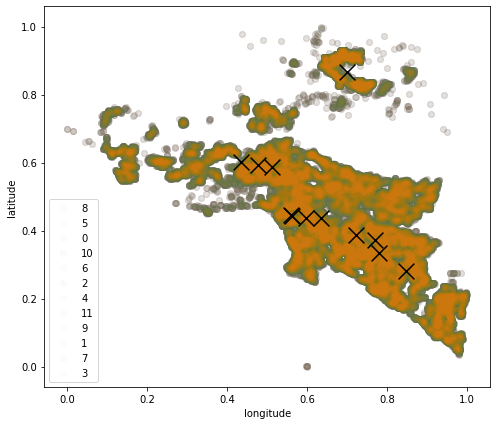

2019-11-07 15:17:03 starting plot_2d_clusters
2019-11-07 15:17:04 ending plot_2d_clusters ; time: 0:00:01.258257


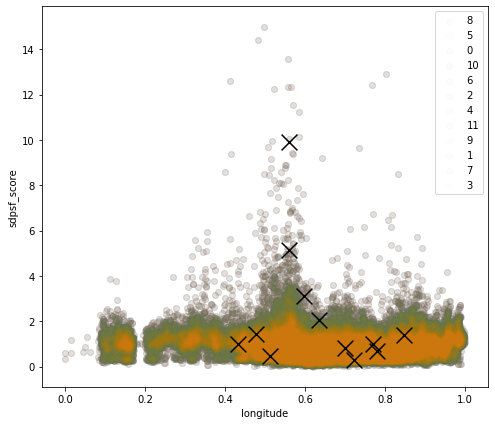

2019-11-07 15:17:22 starting plot_2d_clusters
2019-11-07 15:17:24 ending plot_2d_clusters ; time: 0:00:01.263666


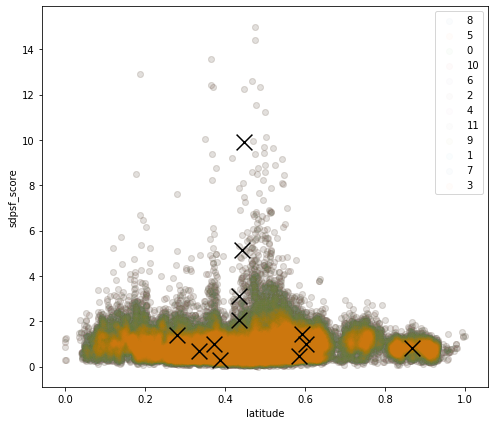

2019-11-07 15:17:41 ending plot_features_2D ; time: 0:00:57.256423


In [61]:
plot_features_2D(features_cl, Xc_scaled)

In [150]:
cluster_y = prep.df_join_xy(Xc_scaled[[cluster_col[0]]], dfo.y) 

2019-11-07 16:11:14 starting df_join_xy
2019-11-07 16:11:14 starting frame_splain
2019-11-07 16:11:14 ending frame_splain ; time: 0:00:00.000200
2019-11-07 16:11:14 ending df_join_xy ; time: 0:00:00.008892


In [97]:
frame_splain(cluster_y, splain=True)

2019-11-07 15:41:39 starting frame_splain
DATAFRAME SHAPE:
(52089, 2) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 2 columns):
cluster     52089 non-null int32
logerror    52089 non-null float64
dtypes: float64(1), int32(1)
memory usage: 3.5 MB
None 

DATAFRAME DESCRIPTION:
            count      mean      std      min       25%       50%       75%  \
cluster   52089.0  5.202154  3.69643  0.00000  2.000000  5.000000  9.000000   
logerror  52089.0  0.018249  0.17599 -4.65542 -0.024575  0.006956  0.040526   

                max  
cluster   11.000000  
logerror   5.262999   

DATAFRAME HEAD:
          cluster  logerror
14297519        8  0.025595
17052889        5  0.055619
14186244        0  0.005383
12177905        5 -0.103410
12095076       10 -0.001011 

2019-11-07 15:41:39 ending frame_splain ; time: 0:00:00.031609


In [210]:
c_col = cluster_col[0]
y_col = dfo.y_column
cluster_stats = (pd.DataFrame(Xc_scaled[c_col].value_counts()) #, columns=['count']
    .reset_index()
    .rename(columns={'index': c_col, c_col: y_col + '_count'})
    .sort_values(by=c_col)
    #.set_index(cluster_col[0])
                )

In [211]:
cluster_stats[y_col + '_mean'] = cluster_stats[c_col].apply(lambda x: cluster_y[cluster_y[c_col] == x][y_col].mean())

In [212]:
cluster_stats[y_col + '_std'] = cluster_stats[c_col].apply(lambda x: cluster_y[cluster_y[c_col] == x][y_col].std())

In [213]:
cluster_stats

,cluster,logerror_count,logerror_mean,logerror_std
0,0,10257,0.022676,0.169724
9,1,640,0.009978,0.181931
3,2,6139,0.015770,0.160302
11,3,39,-0.006551,0.190307
4,4,5061,0.005157,0.157289
5,5,4556,0.020063,0.200163
2,6,7464,0.026393,0.195161
10,7,161,-0.026973,0.362067
6,8,3969,0.022953,0.204216
7,9,3174,0.014994,0.141051


In [100]:
#cluster_stats['mean_logerror']

In [113]:
# cluster_stats.columns=cluster_stats.columns.to_flat_index()

In [118]:
type(cluster_stats.columns)

pandas.core.indexes.multi.MultiIndex

In [142]:
multi_idx = cluster_stats.columns.to_frame

In [134]:
multi_idx

<bound method MultiIndex.to_frame of MultiIndex(levels=[['logerror'], ['count', 'mean', 'std']],
           codes=[[0, 0, 0], [0, 1, 2]])>

In [ ]:
for a in multi_idx(levels[0])

In [140]:
cluster_stats.columns(0,1)

TypeError: 'MultiIndex' object is not callable

In [86]:
df_stats = dfo.y.agg(['count', 'mean', 'std'])
df_stats

,logerror
count,52089.000000
mean,0.018249
std,0.175990
